# 프로젝트 - Movielens 영화 SBR

## 들어가며

### Session-Based Recommendation

- 세션 데이터를 기반으로 **유저가 다음에 클릭 또는 구매할 아이템을 예측하는 추천**을 말한다.  
- Session이란
    - 유저가 서비스를 이용하면서 발생하는 중요한 정보를 담은 데이터를 말하며, 서버 쪽에 저장된다.
    - 유저의 행동 데이터들은 유저 측 브라우저를 통해 쿠키의 형태로 저장되는데 쿠키는 세션과 상호작용하면서 정보를 주고받는다.  


- 이번 프로젝트에서는 세션을 **브라우저가 종료되기 전까지 유저의 행동을 담은 시퀀스 데이터**와 같은 의미로 사용할 것이다. 

- [쿠키, 세션이란?](https://chrisjune-13837.medium.com/web-%EC%BF%A0%ED%82%A4-%EC%84%B8%EC%85%98%EC%9D%B4%EB%9E%80-aa6bcb327582)
- [쿠키, 세션, 캐시 개념 및 차이(초간단 주의)](https://penguingoon.tistory.com/118)

In [1]:
# library load
import numpy as np
import pandas as pd
import tensorflow as tf

import datetime as dt
from pathlib import Path
import os

import warnings
warnings.filterwarnings('ignore')

print(pd.__version__)
print(tf.__version__)

Init Plugin
1.3.5Init Graph Optimizer
Init Kernel

2.5.0


### pathlib
- glob, os.path, shutil에서 사용했던 모든 기능을 pathlib만을 사용하여 구현할 수 있다.
- 파일 시스템 경로를 객체로 다루는 것이 특징이다.
>pathlib 모듈은 파이썬 3.4 버전부터 사용할 수 있다.

    - [pathlib 라이브러리](https://docs.python.org/3/library/pathlib.html)
    - [pathlib - 파일 시스템 경로를 객체로 다루기](https://wikidocs.net/110182)
    - [pathlib 1부:시작하기](https://blog.naver.com/PostView.nhn?blogId=hankrah&logNo=221838907175&categoryNo=0&parentCategoryNo=0&viewDate=&currentPage=1&postListTopCurrentPage=1&from=postView)
    - [pathlib 살펴보기](https://aigong.tistory.com/193)
    


### Dataset Load

-  Movielens 1M Dataset을 기반으로 Session Based Recommendation 시스템을 구현해 보자.

In [2]:
# Movielens 1M Dataset load
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::',
                       header=None, 
                       usecols=[0, 1, 2, 3], 
                       dtype={0: np.int32, 1: np.int32, 2: np.int32}, 
                       nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)

# data를 id와 시간 순서로 정렬
data.sort_values(['UserId', 'Time'], inplace=True)  
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [3]:
# 유저 수(세션 수), 아이템 수, Time 수 확인
print("Unique 한 유저 수  : {:>6}개".format(data['UserId'].nunique()))
print("Unique 한 아이템 수 : {:>6}개".format(data['ItemId'].nunique()))
print("Unique 한 Time 수 : {:>6}개".format(data['Time'].nunique()))

Unique 한 유저 수  :   6040개
Unique 한 아이템 수 :   3706개
Unique 한 Time 수 : 458455개


### 위 데이터 내용 분석  

1. 유저에 대한 정보를 알 수 없다. (성별, 나이, 장소, 마지막 접속 날짜, 이전 구매 내역 등등 )
2. 아이템에 대한 정보도 전혀 알 수 없다. (실제로 어떤 물건인지, 사진이나 설명, 가격)
3. Session에 대한 정보가 없고 `UserID`와 `Time` 항목이 보인다. 이것들을 Session으로 활용해야 할 것 같다.
4. `Time` 항목에는 협정 세계시(`UTC Time`)가 포함되어 있으며 1970.01.01 부터 경과된 '초' 단위의 시간이 기재되어 있다.

- [협정 세계시](https://ko.wikipedia.org/wiki/%ED%98%91%EC%A0%95_%EC%84%B8%EA%B3%84%EC%8B%9C)

### Step 1. 데이터의 전처리
___

### 1-1. Session ID 정의
- `UserID`가 `SessionID` 역할을 할 수 있도록 Session의 기준을 설정한다.

In [4]:
# UserId와 Time을 기준으로 새로운 데이터프레임 생성
mv_df = data.groupby(['UserId', 'Time'])['ItemId'].count().reset_index()
mv_df.reset_index(inplace=True)
mv_df

,index,UserId,Time,ItemId
0,0,1,978300019,1
1,1,1,978300055,3
2,2,1,978300103,1
3,3,1,978300172,1
4,4,1,978300275,1
...,...,...,...,...
471158,471158,6040,997454398,1
471159,471159,6040,997454429,1
471160,471160,6040,997454464,2
471161,471161,6040,997454486,1


In [5]:
# dataframe merge
data = pd.merge(data, mv_df, on=['UserId', 'Time'])

In [6]:
data

,UserId,ItemId_x,Rating,Time,index,ItemId_y
0,1,3186,4,978300019,0,1
1,1,1270,5,978300055,1,3
2,1,1721,4,978300055,1,3
3,1,1022,5,978300055,1,3
4,1,2340,3,978300103,2,1
...,...,...,...,...,...,...
1000204,6040,2917,4,997454429,471159,1
1000205,6040,1921,4,997454464,471160,2
1000206,6040,1784,3,997454464,471160,2
1000207,6040,161,3,997454486,471161,1


In [7]:
# 필요없는 컬럼 drop
data.drop(columns='ItemId_y', inplace=True)
data

,UserId,ItemId_x,Rating,Time,index
0,1,3186,4,978300019,0
1,1,1270,5,978300055,1
2,1,1721,4,978300055,1
3,1,1022,5,978300055,1
4,1,2340,3,978300103,2
...,...,...,...,...,...
1000204,6040,2917,4,997454429,471159
1000205,6040,1921,4,997454464,471160
1000206,6040,1784,3,997454464,471160
1000207,6040,161,3,997454486,471161


In [8]:
# index 컬럼 SessionId 컬럼으로 변경(추가)
data.columns = ['UserId', 'ItemId', 'Rating', 'Time', 'SessionId']

In [9]:
data

,UserId,ItemId,Rating,Time,SessionId
0,1,3186,4,978300019,0
1,1,1270,5,978300055,1
2,1,1721,4,978300055,1
3,1,1022,5,978300055,1
4,1,2340,3,978300103,2
...,...,...,...,...,...
1000204,6040,2917,4,997454429,471159
1000205,6040,1921,4,997454464,471160
1000206,6040,1784,3,997454464,471160
1000207,6040,161,3,997454486,471161


### 1-2 Session Length
___

- 위에서 설정한 `SessionId`를 가지고 몇 개의 영화에 평점을 남겼는지 살펴본다.
- 아래 코드에서 session_length는 같은 SessionId를 공유하는 데이터 행의 수를 의미한다.
- 위의 table을 보면 `SessionId`가 1인 데이터 row의 개수는 3이므로 `SessionId`가 1일 때 3에 대응된다.

In [10]:
session_length = data.groupby('SessionId').size()
session_length

SessionId
0         1
1         3
2         1
3         1
4         1
         ..
471158    1
471159    1
471160    2
471161    1
471162    1
Length: 471163, dtype: int64

- 길이의 요약통계로 중앙값, 평균, 최소값, 최대값 등을 확인해 본다.

In [11]:
# 요약통계 확인
session_length.describe()

count    471163.000000
mean          2.122851
std           1.546899
min           1.000000
25%           1.000000
50%           2.000000
75%           3.000000
max          30.000000
dtype: float64

- 모든 세션에서 최소 하나의 영화에 평점을 남겼으며, 최대 30편의 영화에 평점을 남긴 세션도 있다.

- 평점을 준 횟수에 따른 세션의 수도 알아본다.

In [12]:
length_count = session_length.groupby(session_length).size()
length_count

1     226181
2     110199
3      62860
4      34081
5      18354
6       9656
7       5013
8       2458
9       1232
10       661
11       106
12        83
13        85
14        48
15        38
16        29
17        16
18        13
19         9
20        14
21         6
22         7
23         5
25         2
26         2
27         2
28         2
30         1
dtype: int64

- quantile(A) 메서드로 (A×100)% 범위에 속하는 session_length가 얼마인지 알아본다.
- quantile(A) 메서드에서 A에는 0과 1 사이의 값이 들어간다.

In [13]:
# 90%, 98, 99.9%, 99.99%
print('전체의 90% 정도는', session_length.quantile(0.90), '개의 영화에 평점을 남겼다.')
print('전체의 98% 정도는', session_length.quantile(0.98), '개의 영화에 평점을 남겼다.')  
print('전체의 99.9% 정도는', session_length.quantile(0.999), '개의 영화에 평점을 남겼다.') 
print('전체의 99.99% 정도는', session_length.quantile(0.9999), '개의 영화에 평점을 남겼다.')  

전체의 90% 정도는 4.0 개의 영화에 평점을 남겼다.
전체의 98% 정도는 7.0 개의 영화에 평점을 남겼다.
전체의 99.9% 정도는 10.0 개의 영화에 평점을 남겼다.
전체의 99.99% 정도는 19.0 개의 영화에 평점을 남겼다.


- 전체 세션의 99.99%가 남긴 평점의 개수는 19개였다.
- 길이가 최댓값 30인 세션 중 하나를 집어 살펴본다.
- 실제로 index 값을 하나씩 바꾸어 본 결과, index[1]에서부터 Error가 발생하였다.
- 따라서 평점을 남긴 영화의 편수가 30인 세션은 1개임을 알 수 있다.
- 같은 방법으로 영화의 편수가 29인 세션은 없었으며, 28인 세션은 2개였다!

In [14]:
long_session = session_length[session_length==30].index[0]
data[data['SessionId']==long_session]

,UserId,ItemId,Rating,Time,SessionId
112347,731,3044,4,975528402,55117
112348,731,1455,3,975528402,55117
112349,731,1639,5,975528402,55117
112350,731,3244,4,975528402,55117
112351,731,1656,2,975528402,55117
112352,731,3426,4,975528402,55117
112353,731,1829,2,975528402,55117
112354,731,2675,4,975528402,55117
112355,731,802,3,975528402,55117
112356,731,803,5,975528402,55117


- 아래 코드는 session_length 기준 하위 99.9% 까지의 분포 누적합을 시각화하여 보여준다.
- cumsum() 메서드는 누적 합을 도출하는 메서드이다.
- [cum family](https://rfriend.tistory.com/231)
- 아래 코드의 결과는 session_length가 1인 데이터는 약 48%, 5 이하인 데이터는 약 96% 정도가 분포하고 있음을 알 수 있다. 😉😉😉

In [15]:
# 분포 누적합
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

1    0.480048
2    0.713936
3    0.847350
4    0.919684
5    0.958639
6    0.979132
7    0.989772
8    0.994989
9    0.997604
dtype: float64

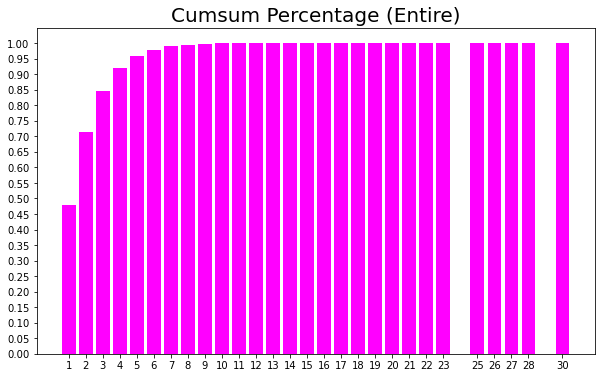

In [16]:
# 전체 분포 누적합 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(x=length_percent_cumsum.index,
        height=length_percent_cumsum, color='magenta')
plt.xticks(length_percent_cumsum.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage (Entire)', size=20)
plt.show()

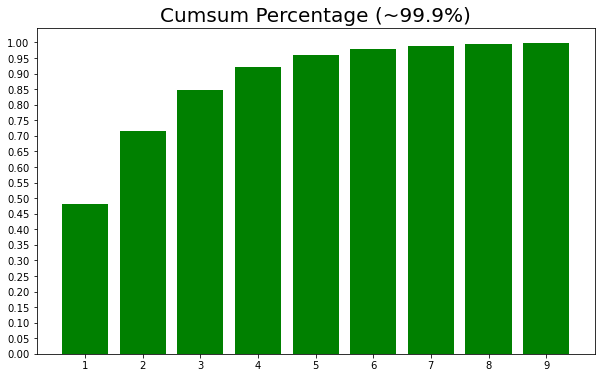

In [17]:
# 하위 99.9%까지의 분포 누적합 시각화

plt.figure(figsize=(10, 6))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='green')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage (~99.9%)', size=20)
plt.show()

### 1-3 Session Time
___

- 이번에는 데이터의 시간 단위 정보에 대해 살펴보자.


In [18]:
# Time 데이터의 초단위 최솟값, 최댓값
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

956703932
1046454590


In [19]:
# oldest, latest 값에 대한 협정 세계시
print(dt.datetime.utcfromtimestamp(oldest).strftime('%Y-%m-%d %H:%M:%S'))   
print(dt.datetime.utcfromtimestamp(latest).strftime('%Y-%m-%d %H:%M:%S')) 

2000-04-25 23:05:32
2003-02-28 17:49:50


- 86400의 의미는 1일을 초(second) 단위로 환산`(24×60×60)`한 값이다. 

In [20]:
print('최근 3년간 Time 데이터 수는', len(data[data['Time'] > latest - (86400*365*3)]), '입니다.')
print('최근 2년간 Time 데이터 수는', len(data[data['Time'] > latest - (86400*365*2)]), '입니다.')
print('최근 1년간 Time 데이터 수는', len(data[data['Time'] > latest - (86400*365*1)]), '입니다.')

최근 3년간 Time 데이터 수는 1000209 입니다.
최근 2년간 Time 데이터 수는 69349 입니다.
최근 1년간 Time 데이터 수는 21704 입니다.


- 위에서 살펴본 session_length 분포가 session_length가 작은 쪽으로 몰려있음을 알 수 있다.
- 추천시스템 구축에서는 최신의 트렌드를 반영하는 것이 효과적이긴 하나, 분포적 특성에 의해 거의 모든 데이터셋을 사용한다.

In [21]:
year_ago = latest - (86400*365*3)     # 최종 날짜로부터 3년 이전 날짜를 구한다.  
data = data[data['Time'] > year_ago]  # 방금 구한 날짜 이후의 데이터만 모은다. 
data

,UserId,ItemId,Rating,Time,SessionId
0,1,3186,4,978300019,0
1,1,1270,5,978300055,1
2,1,1721,4,978300055,1
3,1,1022,5,978300055,1
4,1,2340,3,978300103,2
...,...,...,...,...,...
1000204,6040,2917,4,997454429,471159
1000205,6040,1921,4,997454464,471160
1000206,6040,1784,3,997454464,471160
1000207,6040,161,3,997454486,471161


### 1-4 Data Cleansing
___

- Data Cleansing 단계의 아이디어 : Rating이 낮은 데이터를 어떻게 처리할 것인가?
- 우선, Rating 데이터 또한 매우 많으니, Rating의 최솟값과 최댓값부터 구해보자.

In [22]:
print('유저가 준 평점의 최솟값은', data['Rating'].min(), '점입니다.')
print('유저가 준 평점의 최댓값은', data['Rating'].max(), '점입니다.')

유저가 준 평점의 최솟값은 1 점입니다.
유저가 준 평점의 최댓값은 5 점입니다.


- Rating의 값이 일정 수준 이상인 데이터의 개수를 살펴본다.

In [23]:
print(len(data[data['Rating'] >= 1]))   # 평점의 최솟값이 1이므로 Entire Data의 개수가 나온다.
print(len(data[data['Rating'] >= 2]))   # 평점이 2점 이상인 데이터의 총 개수
print(len(data[data['Rating'] >= 3]))   # 평점이 3점 이상인 데이터의 총 개수
print(len(data[data['Rating'] >= 4]))   # 평점이 4점 이상인 데이터의 총 개수
print(len(data[data['Rating'] >= 5]))   # 평점의 최댓값을 준 데이터의 개수이다.

1000209
944035
836478
575281
226310


In [24]:
data = data[data['Rating'] >= 3]
data = data[['SessionId', 'UserId', 'Time', 'ItemId', 'Rating']]
data

,SessionId,UserId,Time,ItemId,Rating
0,0,1,978300019,3186,4
1,1,1,978300055,1270,5
2,1,1,978300055,1721,4
3,1,1,978300055,1022,5
4,2,1,978300103,2340,3
...,...,...,...,...,...
1000204,471159,6040,997454429,2917,4
1000205,471160,6040,997454464,1921,4
1000206,471160,6040,997454464,1784,3
1000207,471161,6040,997454486,161,3


### 1-5 Train / Valid / Test split
___

- 전체 데이터에서 맨 마지막 날로부터 120일까지를 test set로 정의한다.
- 전체 데이터에서 맨 마지막 날로부터 240일까지 데이터 중 test set이 아닌 데이터를 validation set로 정의한다.


In [25]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('SessionId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - (86400*n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - (86400*n_days)].index

    before_date = data[data['SessionId'].isin(session_in_train)]
    after_date = data[data['SessionId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [26]:
tr, test = split_by_date(data, n_days=120)
tr, val = split_by_date(tr, n_days=120)

In [27]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    first_time = dt.datetime.utcfromtimestamp(data["Time"].min()).strftime('%Y-%m-%d %H:%M:%S')
    last_time = dt.datetime.utcfromtimestamp(data["Time"].max()).strftime('%Y-%m-%d %H:%M:%S')
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {first_time}\n'
          f'\t Last Time : {last_time}\n')

In [28]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 826182
	 Sessions: 6038
	 Items: 3622
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-07-03 16:04:32

* valid Set Stats Info
	 Events: 4939
	 Sessions: 269
	 Items: 1826
	 First Time : 2002-07-03 17:31:04
	 Last Time : 2002-10-31 16:33:08

* test Set Stats Info
	 Events: 5351
	 Sessions: 271
	 Items: 1809
	 First Time : 2002-10-31 19:58:49
	 Last Time : 2003-02-28 17:49:50



In [29]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

- 데이터 준비 및 전처리를 마무리하고 지금까지의 데이터를 저장한다!

In [30]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

### Step 2. 미니 배치의 구성
___


### 2-1 SessionDataset

- 이 과정은 Session-Parallel Mini-Batch를 구현하는 과정이라고 이해하면 된다.

In [31]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['SessionId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['SessionId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('SessionId').size().cumsum()
        return offsets

In [32]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,SessionId,UserId,Time,ItemId,Rating,item_idx
0,0,1,978300019,3186,4,0
1,1,1,978300055,1270,5,1
2,1,1,978300055,1721,4,2
3,1,1,978300055,1022,5,3
4,2,1,978300103,2340,3,4
5,3,1,978300172,1836,5,5
6,4,1,978300275,3408,4,6
7,5,1,978300719,2804,5,7
8,5,1,978300719,1207,4,8
9,6,1,978300760,1193,5,9


- train data로 SessionDataset 객체를 만들고 각 변수들을 살펴본다.

In [33]:
tr_dataset.click_offsets

array([     0,      1,      4, ..., 826180, 826181, 826182], dtype=int32)

In [34]:
tr_dataset.session_idx

array([     0,      1,      2, ..., 415853, 415854, 415855])

### 2-2 SessionDataLoader

- SessionDataset 객체를 받아서 Session-Parallel mini-batch를 만드는 클래스를 하나 설정한다.

In [35]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [36]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,SessionId,UserId,Time,ItemId,Rating,item_idx
0,0,1,978300019,3186,4,0
1,1,1,978300055,1270,5,1
2,1,1,978300055,1721,4,2
3,1,1,978300055,1022,5,3
4,2,1,978300103,2340,3,4
5,3,1,978300172,1836,5,5
6,4,1,978300275,3408,4,6
7,5,1,978300719,2804,5,7
8,5,1,978300719,1207,4,8
9,6,1,978300760,1193,5,9


In [37]:
iter_ex = iter(tr_data_loader)

In [38]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [19  1  7  9]
Label Item Idx are :       [20  2  8 10]
Previous Masked Input Idx are [0]


### Step 3. 모델 구성
___

### 3-1 Evaluation Metric
___

- 이번 프로젝트에서는 평가 지표로 MRR과 Recall을 사용할 것이다.
- 여기서 MRR은 정답 데이터의 index를 역수화한 값이다.


In [39]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

### 3-2 Model Architecture

- 프로젝트에서 사용되는 모델 구조는 노드에서 소개된 GRU4REC을 사용한다.
- [GRU4REC](https://blog.naver.com/stu5073/222208516966)

In [40]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [41]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

- 모델에 사용할 hyper-parameter를 class형식으로 관리하겠습니다.

In [43]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.01, lr=0.00001, epochs=7, k=50)

In [44]:
model = create_model(args)

Metal device set to: Apple M1 Pro
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(256, 1, 3622)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 50), (256, 50)]    551100    
_________________________________________________________________
dropout (Dropout)            (256, 50)                 0         
_________________________________________________________________
dense (Dense)                (256, 3622)               184722    
Total params: 735,822
Trainable params: 735,822
Non-trainable params: 0
_________________________________________________________________


2022-03-16 22:26:31.856934: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-16 22:26:31.857131: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Step 4. 모델 학습
___

### 4-1 Model Training


In [45]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [46]:
# 모델 학습
train_model(model, args)

Train:   0%|                                                     | 0/1602 [00:00<?, ?it/s]2022-03-16 22:28:08.566297: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-03-16 22:28:08.568486: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-03-16 22:28:08.569994: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-16 22:28:08.622423: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-16 22:28:08.676684: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
Evaluation:   0%|                                                   | 0/5 [00:00<?, ?it/s]2022-03-16 22:28:43.798878: I tensorflow/core/grappler/optimizers/custom_graph

	 - Recall@50 epoch 1: 0.036133
	 - MRR@50    epoch 1: 0.009750



Evaluation:  80%|██████████████████████████████████▍        | 4/5 [00:02<00:00,  1.63it/s]


	 - Recall@50 epoch 2: 0.041992
	 - MRR@50    epoch 2: 0.009657



Evaluation:  80%|██████████████████████████████████▍        | 4/5 [00:02<00:00,  1.63it/s]


	 - Recall@50 epoch 3: 0.044922
	 - MRR@50    epoch 3: 0.009475



Evaluation:  80%|██████████████████████████████████▍        | 4/5 [00:02<00:00,  1.64it/s]


	 - Recall@50 epoch 4: 0.044922
	 - MRR@50    epoch 4: 0.009409



Evaluation:  80%|██████████████████████████████████▍        | 4/5 [00:02<00:00,  1.59it/s]


	 - Recall@50 epoch 5: 0.044922
	 - MRR@50    epoch 5: 0.009280



Evaluation:  80%|██████████████████████████████████▍        | 4/5 [00:02<00:00,  1.51it/s]


	 - Recall@50 epoch 6: 0.046875
	 - MRR@50    epoch 6: 0.009439



Evaluation:  80%|██████████████████████████████████▍        | 4/5 [00:02<00:00,  1.58it/s]

	 - Recall@50 epoch 7: 0.046875
	 - MRR@50    epoch 7: 0.009486



### Step 5. 모델 테스트
___

- 테스트 모델함수를 정의하고 모델을 평가한다.

In [47]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  80%|██████████████████████████████████▍        | 4/5 [00:01<00:00,  3.44it/s]

	 - Recall@50: 0.052734
	 - MRR@50: 0.013426



## 회고

- Basic Line으로 시도한 하이퍼파라미터 값은 아래와 같다.
- batch_size = 256, hsz = 50, drop_rate= 0.01, lr = 0.00001, epochs = 7, k = 50


- 멘봉에 의한 의욕저하로 노드에서 진행된 그대로 진행했고 다양한 시도를 해보진 못했다.
- 간신히 프로젝트 제출에 의미를 두며 추후에 자세히 봐야할 것 같다.